# Coffee Bean Classification

### Imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K;
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from glob import glob 
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


## Data

### Loading dataset and checking classes

In [ ]:
data = pd.read_csv('data\Coffee Bean.csv')
data.head()

In [ ]:
classes = sorted(os.listdir('data/train/'))
print(classes)

photos_per_class = [len(glob('data/train/' + name + '/*.png')) for name in classes]
photos_per_class

### Loading images

In [ ]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True, 
        width_shift_range = 0.2, 
        height_shift_range = 0.2,
        shear_range = 0.2, 
        zoom_range = 0.2, 
        validation_split=0.3)

test_data_generator = ImageDataGenerator(rescale=1./255)

train_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='training', class_mode='categorical')
validation_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='validation', class_mode='categorical')
test_data = train_data_generator.flow_from_directory('data/test/', target_size=(224, 224), shuffle=True, 
                                                       class_mode='categorical')

### Images from each class in train and test set

In [ ]:
def show_image(target, bean_class):
    path = target + bean_class
    image = random.sample(os.listdir(path), 1)
    img = mpimg.imread(path + '/' + image[0])
    plt.imshow(img)
    plt.title(bean_class)
    plt.axis('off')

    return img

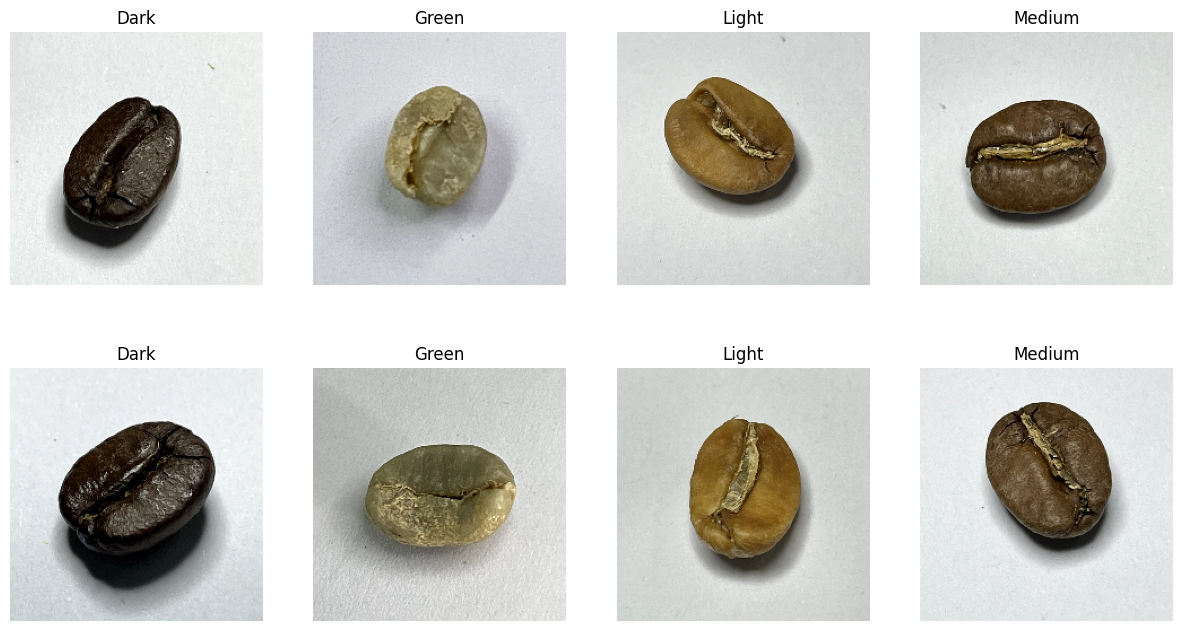

In [8]:
plt.figure(figsize = (15,8))
plt.subplot(2,4,1)
dark_bean_train = show_image('data/train/', 'Dark')
plt.subplot(2,4,2)
green_bean_train = show_image('data/train/', 'Green')
plt.subplot(2,4,3)
light_bean_train = show_image('data/train/', 'Light')
plt.subplot(2,4,4)
medium_bean_train = show_image('data/train/', 'Medium')
plt.subplot(2,4,5)
dark_bean_test = show_image('data/test/', 'Dark')
plt.subplot(2,4,6)
green_bean_test = show_image('data/test/', 'Green')
plt.subplot(2,4,7)
light_bean_test = show_image('data/test/', 'Light')
plt.subplot(2,4,8)
medium_bean_test = show_image('data/test/', 'Medium')

## Models

In [9]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [10]:
def show_results(accuracy_list: list, labels: list):
    accuracy_score = pd.DataFrame(data = accuracy_list, columns = ['Scores'])
    accuracy_score.index = labels
    accuracy_score = (accuracy_score * 100).round(4)
    plt.xticks(rotation=90)
    plt.grid(visible=None)
    plt.scatter(x=accuracy_score.index, y=accuracy_score['Scores'], c=accuracy_score['Scores'], cmap='Dark2_r')
    for i in range(len(accuracy_score['Scores'])):
        plt.annotate(str(accuracy_score['Scores'][i]), (i, accuracy_score['Scores'][i]), textcoords="offset points", xytext=(0,10))
        
accuracy_list = []
labels = []

In [11]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Flatten())
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation='softmax'))

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [13]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [14]:
history_1 = model_1.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=validation_data.samples // 32)

Epoch 1/20
27/27 [==============================] - 25s 521ms/step - loss: 2.2712 - accuracy: 0.3345 - val_loss: 1.2504 - val_accuracy: 0.3977
Epoch 2/20
27/27 [==============================] - 7s 269ms/step - loss: 1.3194 - accuracy: 0.5000 - val_loss: 0.8775 - val_accuracy: 0.6562
Epoch 3/20
27/27 [==============================] - 7s 273ms/step - loss: 0.7992 - accuracy: 0.6369 - val_loss: 0.6773 - val_accuracy: 0.6165
Epoch 4/20
27/27 [==============================] - 7s 282ms/step - loss: 0.7415 - accuracy: 0.7071 - val_loss: 0.4916 - val_accuracy: 0.9148
Epoch 5/20
27/27 [==============================] - 7s 273ms/step - loss: 0.6703 - accuracy: 0.7857 - val_loss: 0.4127 - val_accuracy: 0.8665
Epoch 6/20
27/27 [==============================] - 7s 274ms/step - loss: 0.6063 - accuracy: 0.8702 - val_loss: 0.8702 - val_accuracy: 0.7074
Epoch 7/20
27/27 [==============================] - 8s 294ms/step - loss: 0.4984 - accuracy: 0.8583 - val_loss: 0.3208 - val_accuracy: 0.8977
Epoch

In [15]:
score_1 = model_1.evaluate(test_data)

13/13 [==============================] - 5s 386ms/step - loss: 0.1361 - accuracy: 0.9600


In [16]:
accuracy_list.append(score_1[1])
labels.append('Model 1')

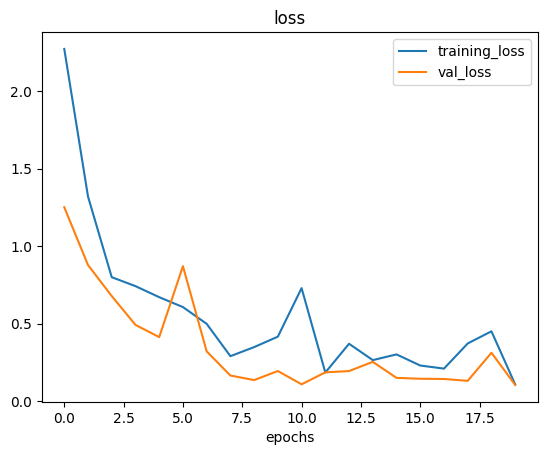

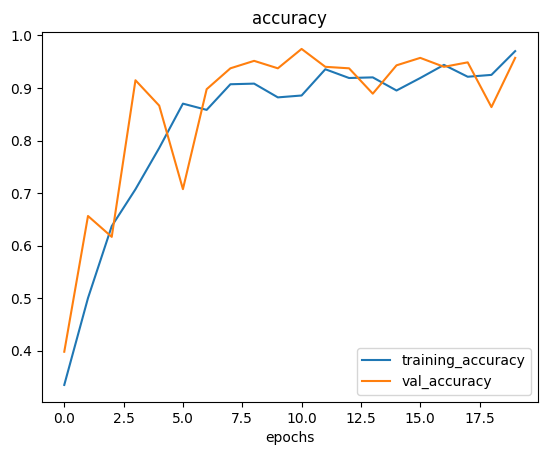

In [17]:
plot_loss_curves(history_1)

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, mode='min')
opt = Adam(lr=0.001)

In [19]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Flatten())
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation='softmax'))

In [20]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [21]:
history_1_aes = model_1.fit(train_data, epochs=40, steps_per_epoch=len(train_data), 
                                    validation_data=validation_data, validation_steps=validation_data.samples // 32,
                                    callbacks=[early_stop],
                                    batch_size=32)

Epoch 1/40
27/27 [==============================] - 8s 285ms/step - loss: 1.6034 - accuracy: 0.3536 - val_loss: 0.9873 - val_accuracy: 0.5682
Epoch 2/40
27/27 [==============================] - 7s 270ms/step - loss: 0.8023 - accuracy: 0.5893 - val_loss: 0.7594 - val_accuracy: 0.5966
Epoch 3/40
27/27 [==============================] - 7s 270ms/step - loss: 0.6149 - accuracy: 0.7000 - val_loss: 0.6564 - val_accuracy: 0.7585
Epoch 4/40
27/27 [==============================] - 7s 270ms/step - loss: 0.4687 - accuracy: 0.8214 - val_loss: 0.4084 - val_accuracy: 0.8523
Epoch 5/40
27/27 [==============================] - 7s 270ms/step - loss: 0.2339 - accuracy: 0.9155 - val_loss: 0.2868 - val_accuracy: 0.8977
Epoch 6/40
27/27 [==============================] - 7s 271ms/step - loss: 0.1410 - accuracy: 0.9512 - val_loss: 0.1148 - val_accuracy: 0.9602
Epoch 7/40
27/27 [==============================] - 7s 268ms/step - loss: 0.1152 - accuracy: 0.9607 - val_loss: 0.1912 - val_accuracy: 0.9290
Epoch 

In [22]:
score_1_aes = model_1.evaluate(test_data)

13/13 [==============================] - 2s 187ms/step - loss: 0.0671 - accuracy: 0.9700


In [23]:
accuracy_list.append(score_1_aes[1])
labels.append('Model 1 - Adam + Early Stop')

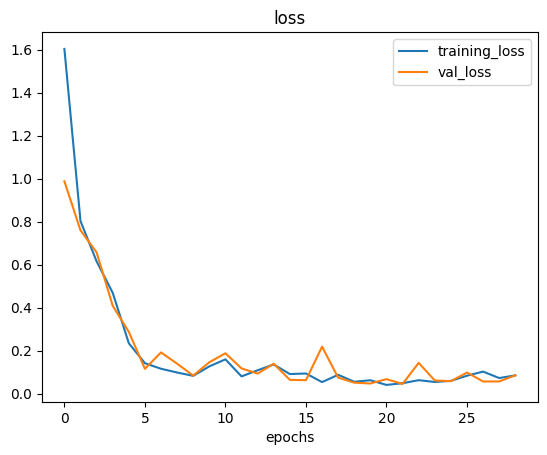

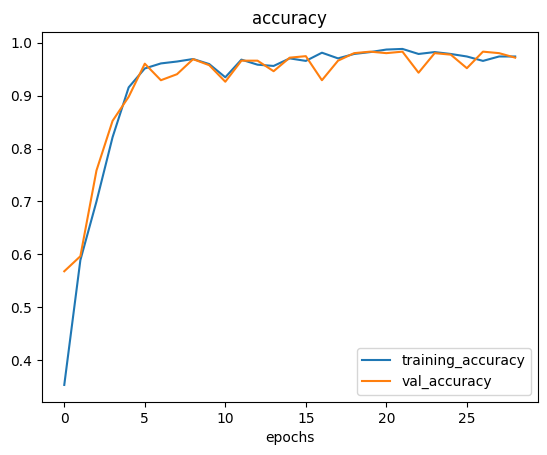

In [24]:
plot_loss_curves(history_1_aes)

In [25]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Flatten())
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(4, activation='softmax'))

In [26]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [27]:
history_2 = model_2.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=int(0.25 * len(validation_data)))

Epoch 1/20
27/27 [==============================] - 7s 225ms/step - loss: 1.4940 - accuracy: 0.3262 - val_loss: 1.2263 - val_accuracy: 0.5104
Epoch 2/20
27/27 [==============================] - 6s 219ms/step - loss: 1.1783 - accuracy: 0.4786 - val_loss: 2.0772 - val_accuracy: 0.2188
Epoch 3/20
27/27 [==============================] - 6s 221ms/step - loss: 0.9398 - accuracy: 0.5179 - val_loss: 0.9702 - val_accuracy: 0.4792
Epoch 4/20
27/27 [==============================] - 6s 227ms/step - loss: 0.8289 - accuracy: 0.6095 - val_loss: 1.0967 - val_accuracy: 0.5625
Epoch 5/20
27/27 [==============================] - 6s 218ms/step - loss: 0.8543 - accuracy: 0.6179 - val_loss: 0.5958 - val_accuracy: 0.7708
Epoch 6/20
27/27 [==============================] - 6s 222ms/step - loss: 0.7044 - accuracy: 0.6464 - val_loss: 0.9371 - val_accuracy: 0.5521
Epoch 7/20
27/27 [==============================] - 6s 224ms/step - loss: 0.7024 - accuracy: 0.6643 - val_loss: 0.7196 - val_accuracy: 0.7917
Epoch 

In [28]:
score_2 = model_2.evaluate(test_data)

13/13 [==============================] - 3s 205ms/step - loss: 0.4101 - accuracy: 0.8400


In [29]:
accuracy_list.append(score_2[1])
labels.append('Model 2')

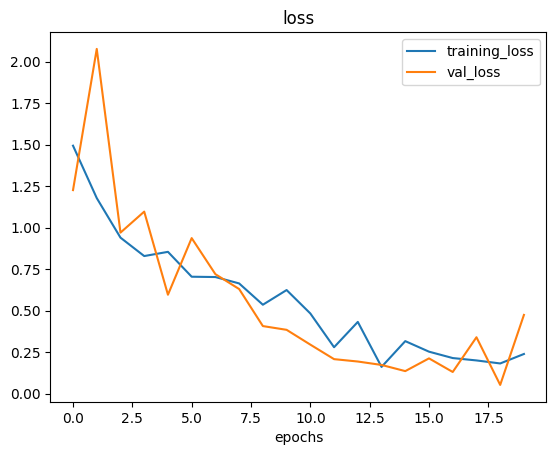

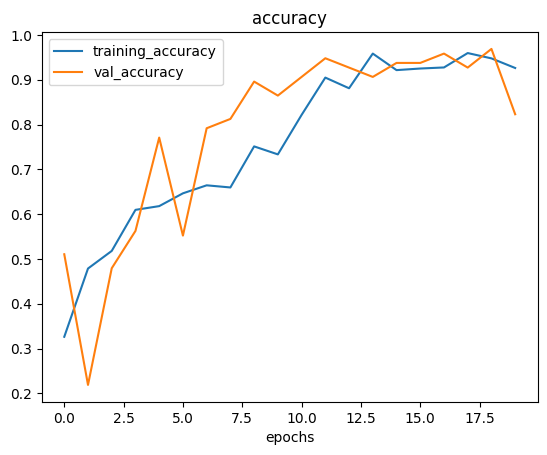

In [30]:
plot_loss_curves(history_2)

In [31]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Flatten())
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(4, activation='softmax'))

In [32]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [33]:
history_2_aes = model_2.fit(train_data, epochs=50, steps_per_epoch=len(train_data), 
                                        validation_data=validation_data, validation_steps=int(0.25 * len(validation_data)),
                                        callbacks=[early_stop])

Epoch 1/50
27/27 [==============================] - 8s 264ms/step - loss: 1.4447 - accuracy: 0.2905 - val_loss: 1.2729 - val_accuracy: 0.4583
Epoch 2/50
27/27 [==============================] - 7s 257ms/step - loss: 1.1244 - accuracy: 0.4702 - val_loss: 0.9699 - val_accuracy: 0.5729
Epoch 3/50
27/27 [==============================] - 7s 243ms/step - loss: 0.8055 - accuracy: 0.6012 - val_loss: 0.7500 - val_accuracy: 0.6771
Epoch 4/50
27/27 [==============================] - 7s 269ms/step - loss: 0.6998 - accuracy: 0.6345 - val_loss: 0.6316 - val_accuracy: 0.7500
Epoch 5/50
27/27 [==============================] - 7s 255ms/step - loss: 0.6653 - accuracy: 0.6976 - val_loss: 0.7813 - val_accuracy: 0.5729
Epoch 6/50
27/27 [==============================] - 6s 234ms/step - loss: 0.5681 - accuracy: 0.7524 - val_loss: 0.4553 - val_accuracy: 0.8125
Epoch 7/50
27/27 [==============================] - 7s 244ms/step - loss: 0.4616 - accuracy: 0.8143 - val_loss: 0.3775 - val_accuracy: 0.8854
Epoch 

In [34]:
score_2_aes = model_2.evaluate(test_data)

13/13 [==============================] - 3s 194ms/step - loss: 0.0460 - accuracy: 0.9875


In [35]:
accuracy_list.append(score_2_aes[1])
labels.append('Model 2 - Adam + Early Stop')

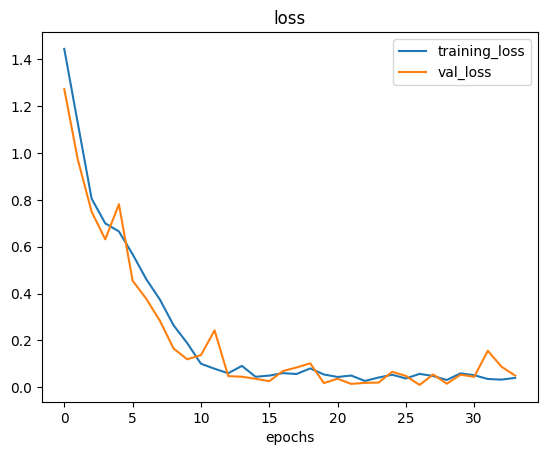

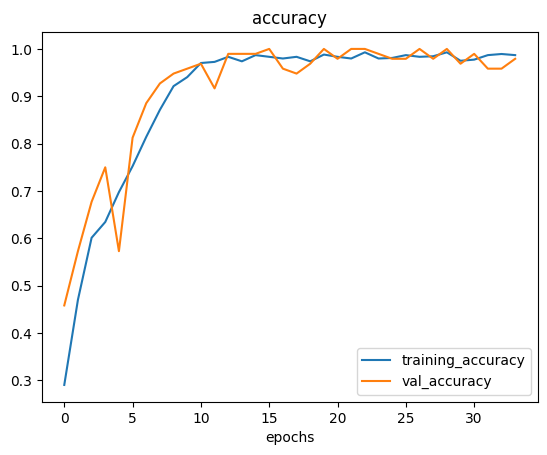

In [36]:
plot_loss_curves(history_2_aes)

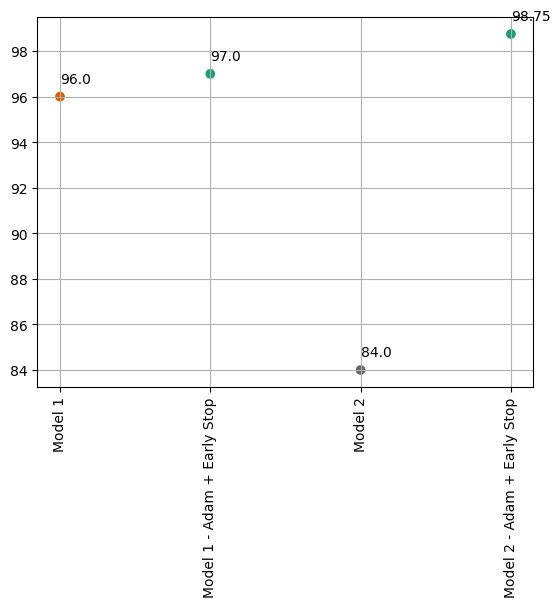

In [37]:
show_results(accuracy_list, labels)

In [55]:
model_2.save('best_model')

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


### Custom Loss Function

In [38]:
def customLossFunc(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

In [39]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Flatten())
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation='softmax'))

In [40]:
model_1.compile(loss = customLossFunc, optimizer = 'rmsprop', metrics=['accuracy'])

In [41]:
history_1_with_custom = model_1.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=validation_data.samples // 32)

Epoch 1/20
27/27 [==============================] - 9s 304ms/step - loss: 2.2860 - accuracy: 0.3571 - val_loss: 1.0689 - val_accuracy: 0.5170
Epoch 2/20
27/27 [==============================] - 8s 280ms/step - loss: 0.9640 - accuracy: 0.6190 - val_loss: 0.8260 - val_accuracy: 0.6705
Epoch 3/20
27/27 [==============================] - 8s 278ms/step - loss: 0.5706 - accuracy: 0.7643 - val_loss: 0.3667 - val_accuracy: 0.8580
Epoch 4/20
27/27 [==============================] - 7s 276ms/step - loss: 0.8603 - accuracy: 0.7821 - val_loss: 0.3004 - val_accuracy: 0.9091
Epoch 5/20
27/27 [==============================] - 8s 295ms/step - loss: 0.3368 - accuracy: 0.8893 - val_loss: 0.3842 - val_accuracy: 0.8580
Epoch 6/20
27/27 [==============================] - 8s 287ms/step - loss: 0.6518 - accuracy: 0.8857 - val_loss: 0.2540 - val_accuracy: 0.8949
Epoch 7/20
27/27 [==============================] - 8s 277ms/step - loss: 0.3195 - accuracy: 0.8845 - val_loss: 0.2586 - val_accuracy: 0.8778
Epoch 

In [42]:
score_1_with_custom = model_1.evaluate(test_data)

13/13 [==============================] - 3s 196ms/step - loss: 1.4092 - accuracy: 0.6100


In [43]:
print('Score without custom loss: ' + str(score_1[1] * 100))
print('Score with custom loss: ' + str(score_1_with_custom[1] * 100))

Score without custom loss: 95.99999785423279
Score with custom loss: 61.000001430511475


### Overfitting

#### Model without Dropout layer and with more epochs

In [44]:
model_3 = Sequential()
model_3.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_3.add(MaxPooling2D(2,2))
model_3.add(Conv2D(32, (3,3), activation="relu"))
model_3.add(MaxPooling2D(2,2))
model_3.add(Conv2D(32, (3,3), activation="relu"))
model_3.add(MaxPooling2D(2,2))
model_3.add(Flatten())
model_3.add(Dense(512, activation="relu"))
model_3.add(Dense(4, activation='softmax'))

In [45]:
model_3.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [46]:
history_3 = model_3.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=validation_data.samples // 32)

Epoch 1/100
27/27 [==============================] - 9s 293ms/step - loss: 2.7942 - accuracy: 0.3310 - val_loss: 1.3866 - val_accuracy: 0.3011
Epoch 2/100
27/27 [==============================] - 8s 287ms/step - loss: 1.0106 - accuracy: 0.5179 - val_loss: 1.0003 - val_accuracy: 0.5028
Epoch 3/100
27/27 [==============================] - 8s 281ms/step - loss: 0.9211 - accuracy: 0.6131 - val_loss: 1.8229 - val_accuracy: 0.2926
Epoch 4/100
27/27 [==============================] - 8s 303ms/step - loss: 0.6083 - accuracy: 0.7238 - val_loss: 1.9072 - val_accuracy: 0.5114
Epoch 5/100
27/27 [==============================] - 8s 283ms/step - loss: 0.6510 - accuracy: 0.7929 - val_loss: 0.2894 - val_accuracy: 0.9006
Epoch 6/100
27/27 [==============================] - 8s 284ms/step - loss: 0.3362 - accuracy: 0.8738 - val_loss: 1.6126 - val_accuracy: 0.5085
Epoch 7/100
27/27 [==============================] - 8s 283ms/step - loss: 0.3760 - accuracy: 0.8893 - val_loss: 0.6860 - val_accuracy: 0.7102

In [47]:
score_3 = model_3.evaluate(test_data)

13/13 [==============================] - 3s 191ms/step - loss: 0.0166 - accuracy: 0.9900


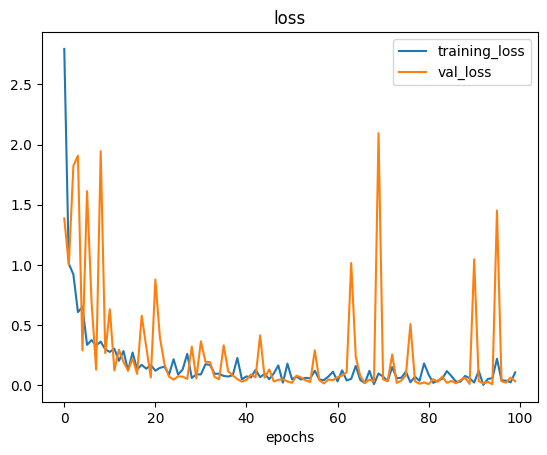

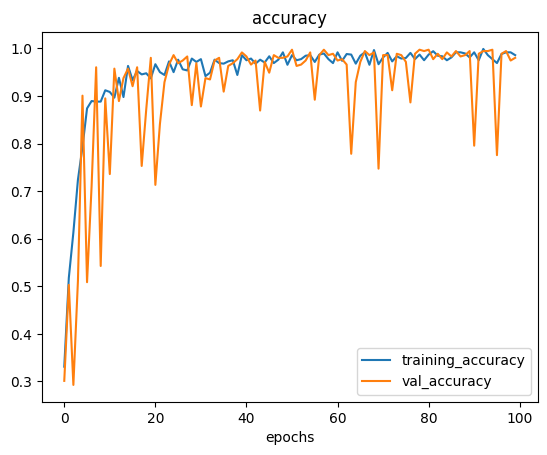

In [48]:
plot_loss_curves(history_3)

#### Less images and no augmentation

In [49]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.6)

train_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='training', class_mode='categorical')

Found 480 images belonging to 4 classes.


In [50]:
model_4 = Sequential()
model_4.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_4.add(MaxPooling2D(2,2))
model_4.add(Conv2D(32, (3,3), activation="relu"))
model_4.add(MaxPooling2D(2,2))
model_4.add(Conv2D(32, (3,3), activation="relu"))
model_4.add(MaxPooling2D(2,2))
model_4.add(Conv2D(32, (3,3), activation="relu"))
model_4.add(MaxPooling2D(2,2))
model_4.add(Flatten())
model_4.add(Dense(512, activation="relu"))
model_4.add(Dense(4, activation='softmax'))

In [51]:
model_4.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [52]:
history_4 = model_4.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=test_data.samples // 32)

Epoch 1/100
15/15 [==============================] - 5s 270ms/step - loss: 1.4772 - accuracy: 0.3708 - val_loss: 1.3690 - val_accuracy: 0.2578
Epoch 2/100
15/15 [==============================] - 4s 237ms/step - loss: 1.2128 - accuracy: 0.4479 - val_loss: 1.0371 - val_accuracy: 0.5807
Epoch 3/100
15/15 [==============================] - 3s 233ms/step - loss: 1.0190 - accuracy: 0.5792 - val_loss: 1.0900 - val_accuracy: 0.4427
Epoch 4/100
15/15 [==============================] - 3s 237ms/step - loss: 0.7136 - accuracy: 0.6333 - val_loss: 0.9180 - val_accuracy: 0.6172
Epoch 5/100
15/15 [==============================] - 4s 233ms/step - loss: 0.5556 - accuracy: 0.8062 - val_loss: 0.7524 - val_accuracy: 0.6276
Epoch 6/100
15/15 [==============================] - 3s 238ms/step - loss: 0.4851 - accuracy: 0.8146 - val_loss: 0.9010 - val_accuracy: 0.6484
Epoch 7/100
15/15 [==============================] - 4s 252ms/step - loss: 0.5396 - accuracy: 0.8625 - val_loss: 1.3284 - val_accuracy: 0.4948

In [53]:
score_4 = model_4.evaluate(test_data)

13/13 [==============================] - 3s 189ms/step - loss: 2.7774 - accuracy: 0.7250


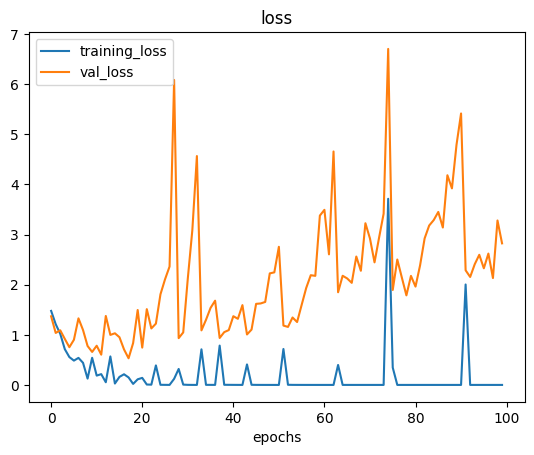

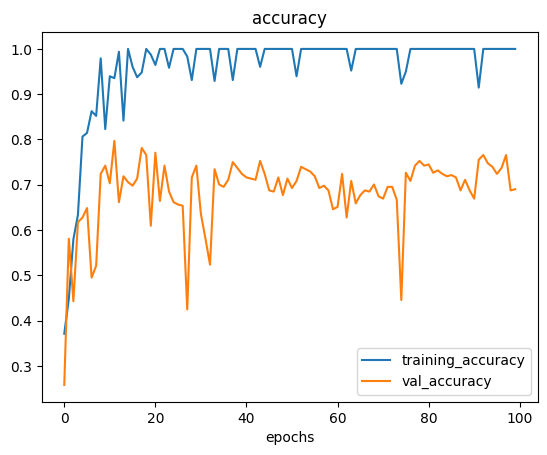

In [54]:
plot_loss_curves(history_4)